# Detect a pulse

In [1]:
import tempfile
from urllib import request

import jess.JESS_filters as Jf
import matplotlib.pyplot as plt
import numpy as np
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import detect
from your import Your
from your.formats.filwriter import make_sigproc_object

In [2]:
def show_dynamic(dynamic_spectra: np.ndarray, title: str = None, save: bool = False):
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std)
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title + ".png", dpi=200)

# Get chunk of search mode dynamic spectra

In [3]:
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
B1828_fil = temp_dir.name + "/B1828.fil"
request.urlretrieve("https://zenodo.org/record/5866463/files/B1828.fil", B1828_fil)

('/tmp/tmptj44vgfc/B1828.fil', <http.client.HTTPMessage at 0x7f0f68dd5f40>)

In [4]:
yr_obj = Your(B1828_fil)
dynamic_spectra = yr_obj.get_data(0, 16384)

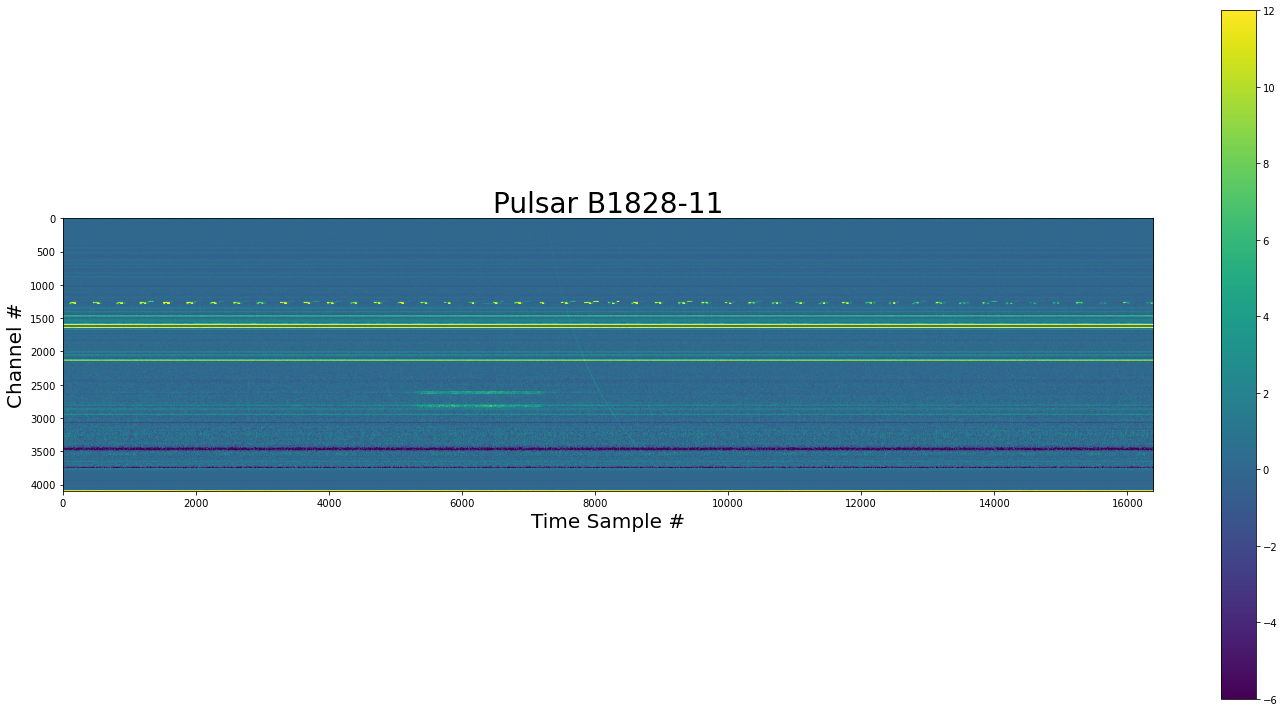

In [5]:
show_dynamic(dynamic_spectra, title="Pulsar B1828-11")

# Make the dedispersed time series

In [6]:
time_series = detect.dedisped_time_series(
    dynamic_spectra,
    dm=159.70,  # from psrcat
    tsamp=yr_obj.your_header.tsamp,
    chan_freqs=yr_obj.chan_freqs,
)

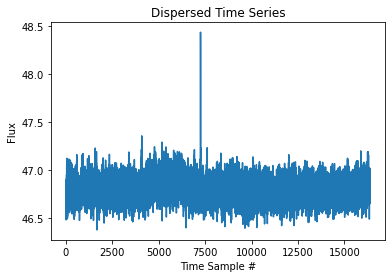

In [7]:
plt.title("Dispersed Time Series")
plt.xlabel("Time Sample #")
plt.ylabel("Flux")
plt.plot(time_series)

# Detect Pulses

In [8]:
sigma = 6
pulses = detect.detect_pulses(time_series, box_car_length=8, sigma=sigma)
print(f"Time series Standard Deviation: {pulses.std:.3f}")

Time series Standard Deviation: 0.101


Text(0.5, 0, 'Locations')

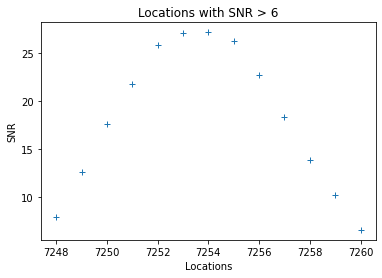

In [9]:
plt.title(f"Locations with SNR > {sigma}")
plt.plot(pulses.locations, pulses.snrs, "+")
plt.ylabel("SNR")
plt.xlabel("Locations")

We have a range of points because the pulse is over several boxcars

## Find largest pulse over range

In [10]:
print(detect.find_max_pulse(pulses, 7000, 8000))

MaxPulse(location=7254, snr=27.18110938404581)


The GREENBURST pipeline reported an SNR of 28.4 (this pipeline has RFI mitigation, so some difference is expected)

# Repeat with RFI Mitigation

In [11]:
mad_cleaned = Jf.mad_spectra_flat(dynamic_spectra, sigma=4)
fft_cleaned = Jf.fft_mad(mad_cleaned.dynamic_spectra, sigma=4)
print(
    f"MAD Flagged: {mad_cleaned.percent_masked:.2f}, FFT Flagged: {fft_cleaned.percent_masked:.2f}, Total: {mad_cleaned.percent_masked+fft_cleaned.percent_masked:.2f}"
)

/home/jkania/programs/miniconda3/envs/kpe/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/jkania/programs/miniconda3/envs/kpe/lib/python3.8/site-packages/jess/calculators.py:418: RuntimeWarning: Mean of empty slice
  spectra_means = np.nanmean(dynamic_spectra, axis=0)


MAD Flagged: 1.25, FFT Flagged: 0.36, Total: 1.61


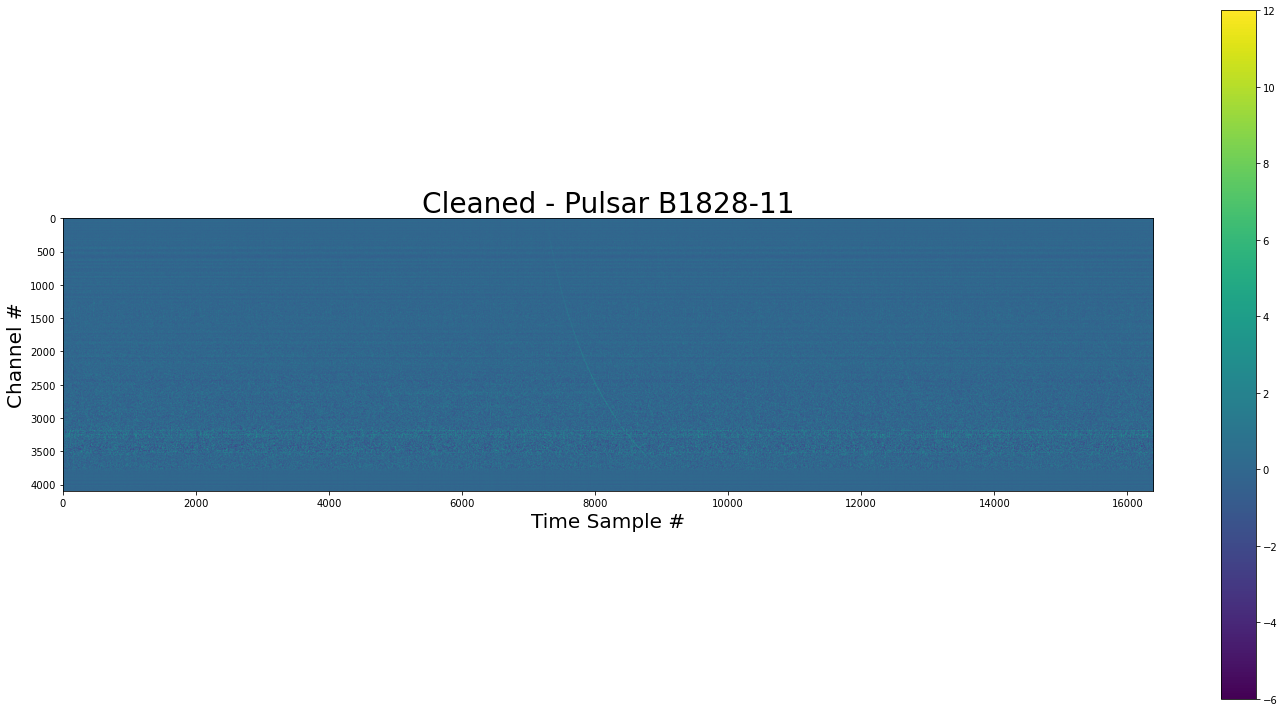

In [12]:
show_dynamic(fft_cleaned.dynamic_spectra, title="Cleaned - Pulsar B1828-11")

In [13]:
time_series_clean = detect.dedisped_time_series(
    fft_cleaned.dynamic_spectra,
    dm=159.70,  # from psrcat
    tsamp=yr_obj.your_header.tsamp,
    chan_freqs=yr_obj.chan_freqs,
)

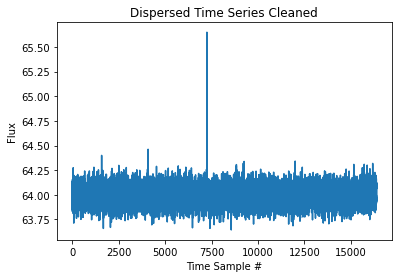

In [14]:
plt.title("Dispersed Time Series Cleaned")
plt.xlabel("Time Sample #")
plt.ylabel("Flux")
plt.plot(time_series_clean)

In [15]:
pulses_clean = detect.detect_pulses(time_series_clean, box_car_length=8, sigma=sigma)
print(f"Time series Standard Deviation: {pulses_clean.std:.3f}")

Time series Standard Deviation: 0.084


Text(0.5, 0, 'Locations')

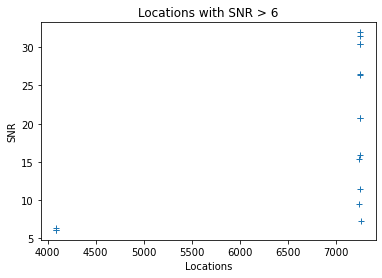

In [16]:
plt.title(f"Locations with SNR > {sigma}")
plt.plot(pulses_clean.locations, pulses_clean.snrs, "+")
plt.ylabel("SNR")
plt.xlabel("Locations")

In [17]:
print(detect.find_max_pulse(pulses_clean, 7000, 8000))

MaxPulse(location=7253, snr=31.95986990522754)
